# Install deps

In [ ]:
! pip install -r requirements.txt

#### Create a local_secrets.py file containing the following details: 
###### client_id=\<YOUR_CLIENT_ID\> 
###### client_secret=\<YOUR_SECRET_ID\>
###### token=\<YOUR_TOKEN\>
###### db_keyspace=\<YOUR_KEYSPACE_NAME\>
###### secure_bundle_path=\<FULL_PATH_TO_YOUR_SECURITY_BUNDLE.zip\>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [4]:
from local_secrets import *
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

## Renaming data

In [5]:
orig_data = pd.read_csv('./data/DELL.csv')
new_headers = {'Date': 'date', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adj_close', 'Volume': 'volume'}
data = orig_data.rename(columns=new_headers)

## Inserting data into the DB

In [6]:
## Astra Configuration
cloud_config= {
  'secure_connect_bundle': secure_bundle_path
}
auth_provider = PlainTextAuthProvider(client_id, client_secret)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

session.execute(f'USE {db_keyspace}')

### 1. create training_data table

In [45]:
query = """
CREATE TABLE IF NOT EXISTS training_data (
    date text,
    open float,
    high float,
    low float,
    close float,
    adj_close float,
    volume float,
    PRIMARY KEY (date)
)
"""
session.execute(query)

### 1. Inserting data into training_data

In [ ]:
for row in data.itertuples(index=False):
    query = f"INSERT INTO training_data (date, open, high, low, close, adj_close, volume) VALUES ('{row[0]}', {row[1]}, {row[2]}, {row[3]}, {row[4]}, {row[5]}, {row[6]})"
    session.execute(query)

## Retrieving data from Astra DB

In [9]:
# Retrieve data from the table
query = "SELECT * FROM training_data"
result_set = session.execute(query)

# Convert the result set to a pandas DataFrame
data = pd.DataFrame(list(result_set)).sort_values(by=['date'])

## Data Statistics

In [10]:
print(data.shape)
print(data.sample(7))

(912, 7)
                    date  adj_close      close       high        low   
647  2017-07-25 00:00:00  35.287930  35.049835  35.276855  35.542637  \
463  2017-01-25 00:00:00  33.222591  32.967884  33.255814  33.405315   
62   2017-11-22 00:00:00  45.470654  44.673309  44.734219  45.625690   
214  2019-07-05 00:00:00  52.130001  51.790001  52.369999  52.650002   
850  2016-11-25 00:00:00  28.466223  28.433001  28.898117  29.025471   
754  2019-04-15 00:00:00  63.599998  63.070000  63.880001  63.970001   
798  2019-10-14 00:00:00  50.250000  50.110001  50.680000  50.750000   

          open     volume  
647  35.276855  1109200.0  
463  33.255814  2967200.0  
62   44.734219  2676100.0  
214  52.369999  2093700.0  
850  28.898117   458700.0  
754  63.880001  1161200.0  
798  50.680000   786200.0  


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 511 to 439
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       912 non-null    object 
 1   adj_close  912 non-null    float64
 2   close      912 non-null    float64
 3   high       912 non-null    float64
 4   low        912 non-null    float64
 5   open       912 non-null    float64
 6   volume     912 non-null    float64
dtypes: float64(6), object(1)
memory usage: 57.0+ KB


In [12]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 511 to 439
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       912 non-null    datetime64[ns]
 1   adj_close  912 non-null    float64       
 2   close      912 non-null    float64       
 3   high       912 non-null    float64       
 4   low        912 non-null    float64       
 5   open       912 non-null    float64       
 6   volume     912 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 57.0 KB


#### Open and Close prices over time for DELL Stock Markets

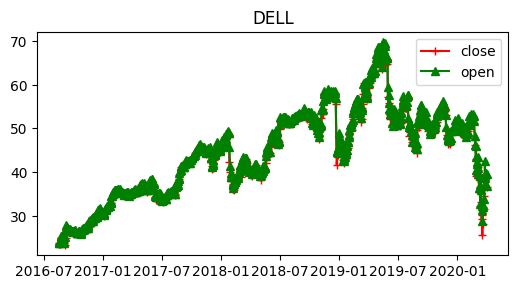

In [13]:
data['date'] = pd.to_datetime(data['date'])
companies = ['DELL', 'GOOGL']
company = 'DELL'
# date vs open
# date vs close
plt.figure(figsize=(15, 8))
#for index, company in enumerate(companies, 1):
plt.subplot(3, 3, 1)
c = data
plt.plot(c['date'], c['close'], c="r", label="close", marker="+")
plt.plot(c['date'], c['open'], c="g", label="open", marker="^")
plt.title(company)
plt.legend()
plt.tight_layout()

#### Volume of shares traded per a price level for DELL Company

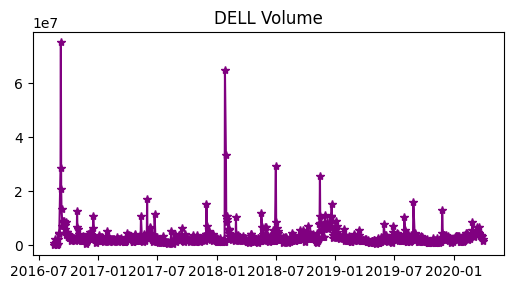

In [14]:
plt.figure(figsize=(15, 8))
#for index, company in enumerate(companies, 1):
plt.subplot(3, 3, 1)
c = data
plt.plot(c['date'], c['volume'], c='purple', marker='*')
plt.title(f"{company} Volume")
plt.tight_layout()

#### Dell Stock (Close) Prices over time

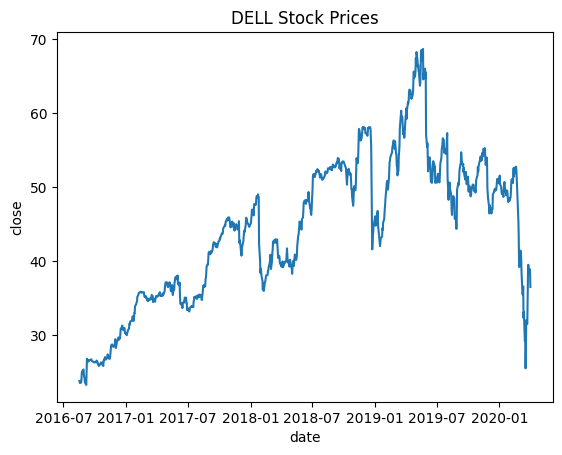

In [15]:
dell = data
prediction_range = dell.loc[(dell['date'] > datetime(2013,1,1))
 & (dell['date']<datetime(2018,1,1))]
plt.plot(dell['date'],dell['close'])
plt.xlabel("date")
plt.ylabel("close")
plt.title("DELL Stock Prices")
plt.show()

#### splitting data into 95% training and 5% test

In [16]:
close_data = dell.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

867


## Building the model

#### Applying the train test split on the data and normalizing the values (betwen 0 and 1)

In [17]:
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []
 
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#### Defining the model: LSTM model

In [18]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x2c7142800>>

#### Defining the optimizer and running the fit / trainning operation

In [19]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10
26/26 [==============================] - 2s 29ms/step - loss: 0.0432
Epoch 2/10
26/26 [==============================] - 1s 22ms/step - loss: 0.0150
Epoch 3/10
26/26 [==============================] - 1s 22ms/step - loss: 0.0137
Epoch 4/10
26/26 [==============================] - 1s 23ms/step - loss: 0.0131
Epoch 5/10
26/26 [==============================] - 1s 23ms/step - loss: 0.0123
Epoch 6/10
26/26 [==============================] - 1s 23ms/step - loss: 0.0099
Epoch 7/10
26/26 [==============================] - 1s 22ms/step - loss: 0.0118
Epoch 8/10
26/26 [==============================] - 1s 23ms/step - loss: 0.0105
Epoch 9/10
26/26 [==============================] - 1s 24ms/step - loss: 0.0098
Epoch 10/10
26/26 [==============================] - 1s 23ms/step - loss: 0.0102


#### Runining the predict or test operation on the test dataset and compute error metrics (RMSE and MSE)

In [20]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
 
# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
 
# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
rmse = np.sqrt(mse)
print("MSE", mse)
print("RMSE", rmse)

2/2 [==============================] - 0s 5ms/step
MSE 19.90124716839451
RMSE 4.461081390021315


## Forecast vs Sales

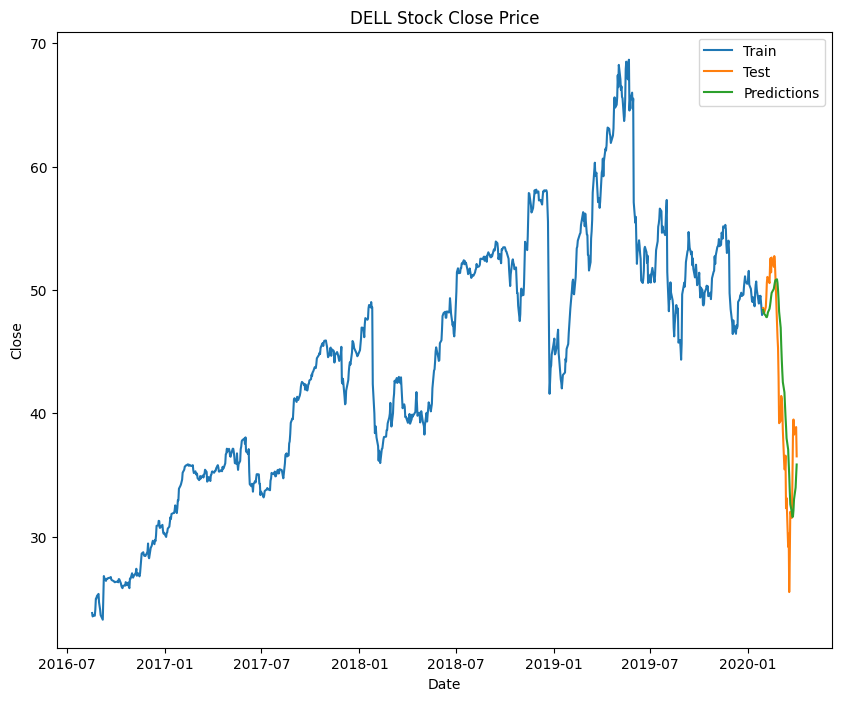

In [44]:
train = dell[:training]
test = dell[training:]
test['Predictions'] = predictions
 
plt.figure(figsize=(10, 8))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close', 'Predictions']])
plt.title('DELL Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])

#### Print the summary of the model

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52033 (203.25 KB)
Trainable params: 52033 (203.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
model_table_name="model_table"

#### Store the model in AstraDB with the error metrics

In [25]:
session.execute(f"CREATE TABLE IF NOT EXISTS {model_table_name} (model_name TEXT PRIMARY KEY, model_data BLOB, rmse double, mse double);")

In [26]:
import io
model_json = model.to_json()

In [27]:
import json
prepared_stmt = session.prepare(f"""
    INSERT INTO {model_table_name} (model_name, model_data, rmse, mse)
    VALUES (?, ?, ?, ?)
""")

model_name = 'demo_model_h5'  # Replace with your desired model name

session.execute(prepared_stmt, (model_name, bytearray(json.dumps(model_json).encode('utf-8')), rmse, mse))

#### read the stored model and load it again

In [36]:
model_output = session.execute(f"select model_data from {model_table_name} where model_name='{model_name}';")

In [37]:
json_blob = None
for row in model_output:
    json_blob = row.model_data

if json_blob is None:
    raise ValueError(f"model with name '{model_name}' not found in the database.")

# Decode the blob data to string
decoded_json_blob = json_blob.decode('utf-8')

# Parse the JSON string into a JSON object
json_data = json.loads(decoded_json_blob)

In [38]:
# Create a new model with the same architecture
loaded_model = tf.keras.models.model_from_json(json_data)

In [39]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52033 (203.25 KB)
Trainable params: 52033 (203.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
new_predictions = loaded_model.predict(x_test)
new_predictions = scaler.inverse_transform(new_predictions)
 
# evaluation metrics
new_mse = np.mean(((new_predictions - y_test) ** 2))
new_rmse = np.sqrt(new_mse)
print("MSE", new_mse)
print("RMSE", new_rmse)

2/2 [==============================] - 0s 9ms/step
MSE 437.08560811051194
RMSE 20.906592455742565
